# Air Pollution Forecasting

Dataset: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data
    
This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.
The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

No: row number

year: year of data in this row

month: month of data in this row

day: day of data in this row

hour: hour of data in this row

pm2.5: PM2.5 concentration

DEWP: Dew Point

TEMP: Temperature

PRES: Pressure

cbwd: Combined wind direction

Iws: Cumulated wind speed

Is: Cumulated hours of snow

Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

#  LSTM
Long Short Term Memory networks

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.
As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.
Instead of neurons, LSTM networks have memory blocks that are connected through layers.A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

Forget Gate: conditionally decides what information to throw away from the block.

Input Gate: conditionally decides which values from the input to update the memory state.

Output Gate: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

We can see how we may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

1. Data cleaning
2. Use heatmap to see corelation between variables
3. plot each column
4. All features are normalized, then the dataset is transformed into a supervised learning problem
5. Design network

In [23]:
from IPython.display import display, Markdown
from math import sqrt
import tensorflow as tf
from numpy import concatenate
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize']=10,8
#from keras.layers import LSTM



In [24]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset1 = read_csv('timeseries_train.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset2 = read_csv('timeseries_test.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset=pd.concat([dataset1,dataset2]) 

In [25]:
dataset.isnull().sum()

pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [26]:
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [27]:
dataset.isnull().sum()

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [28]:
def report(df):
    display(Markdown('<b>head():</b>'))
    display(df.head())
    display(Markdown('<b>describe():</b>'))
    display(df.describe())
    display(Markdown('<b>info():</b>'))
    display(df.info(verbose=True))
    display(Markdown('<b>infer_dtype():</b>'))
    display(df.apply(lambda x: pd.api.types.infer_dtype(x.values)))

In [29]:
report(dataset)

<b>head():</b>

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


<b>describe():</b>

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


<b>info():</b>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pollution    43800 non-null float64
dew          43800 non-null int64
temp         43800 non-null float64
press        43800 non-null float64
wnd_dir      43800 non-null object
wnd_spd      43800 non-null float64
snow         43800 non-null int64
rain         43800 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


None

<b>infer_dtype():</b>

pollution    floating
dew           integer
temp         floating
press        floating
wnd_dir        string
wnd_spd      floating
snow          integer
rain          integer
dtype: object

In [30]:
dataset.shape

(43800, 8)

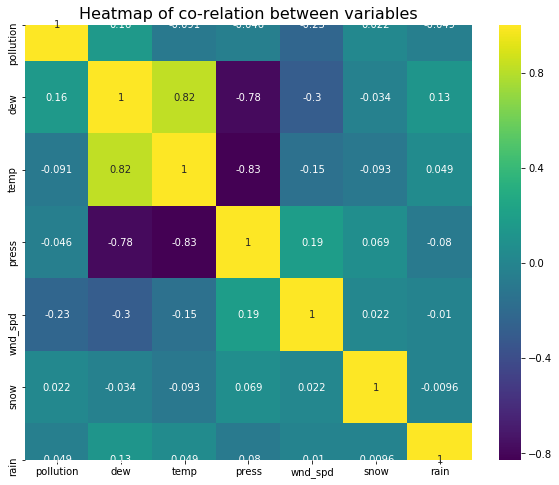

In [31]:
#Use heatmap to see corelation between variables
sns.heatmap(dataset.corr(),annot=True,cmap='viridis')
plt.title('Heatmap of co-relation between variables',fontsize=16)
plt.show()

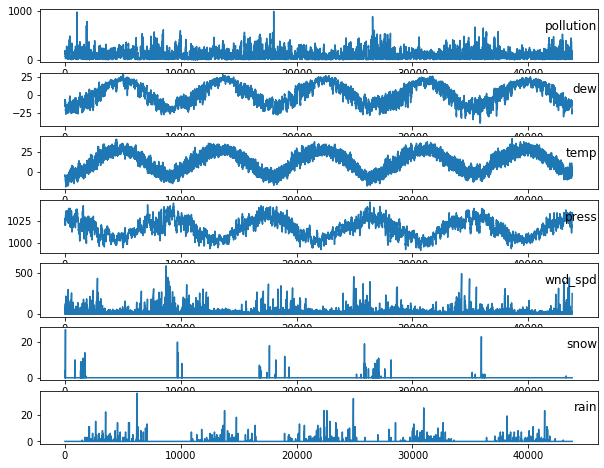

In [32]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

# All features are normalized, then the dataset is transformed into a supervised learning problem

In [33]:
# convert series to supervised learning
"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [34]:
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [35]:
reframed.shape

(43799, 16)

In [36]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


 The inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features]

In [37]:

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


# Design network

Fit an LSTM on the multivariate input data

Fit an GRU on the multivariate input data

In [38]:
import warnings;
warnings.filterwarnings('ignore');

# design network

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)
# To save model
model.save('LSTM_model.hdf5')
# Training Phase
model.summary()

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0620 - val_loss: 0.0491
Epoch 2/50
 - 1s - loss: 0.0415 - val_loss: 0.0487
Epoch 3/50
 - 1s - loss: 0.0236 - val_loss: 0.0449
Epoch 4/50
 - 1s - loss: 0.0168 - val_loss: 0.0360
Epoch 5/50
 - 1s - loss: 0.0154 - val_loss: 0.0235
Epoch 6/50
 - 1s - loss: 0.0151 - val_loss: 0.0192
Epoch 7/50
 - 1s - loss: 0.0150 - val_loss: 0.0183
Epoch 8/50
 - 1s - loss: 0.0149 - val_loss: 0.0173
Epoch 9/50
 - 1s - loss: 0.0148 - val_loss: 0.0160
Epoch 10/50
 - 1s - loss: 0.0147 - val_loss: 0.0153
Epoch 11/50
 - 1s - loss: 0.0148 - val_loss: 0.0147
Epoch 12/50
 - 1s - loss: 0.0146 - val_loss: 0.0144
Epoch 13/50
 - 1s - loss: 0.0147 - val_loss: 0.0139
Epoch 14/50
 - 1s - loss: 0.0145 - val_loss: 0.0138
Epoch 15/50
 - 1s - loss: 0.0145 - val_loss: 0.0135
Epoch 16/50
 - 1s - loss: 0.0145 - val_loss: 0.0135
Epoch 17/50
 - 1s - loss: 0.0145 - val_loss: 0.0134
Epoch 18/50
 - 1s - loss: 0.0145 - val_loss: 0.0135
Epoch 19/50
 - 1s - loss

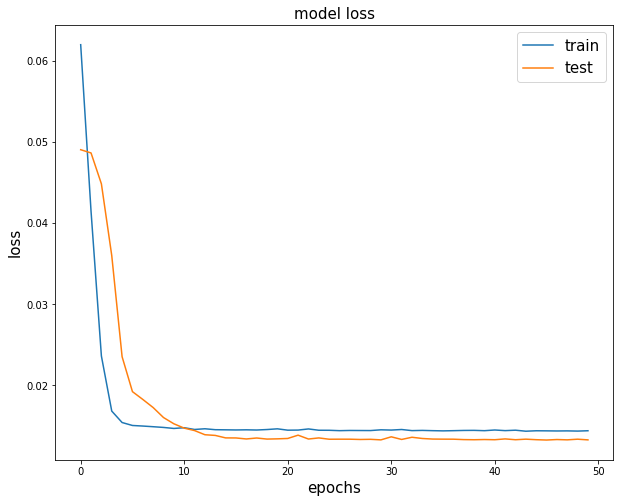

In [39]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

pyplot.title('model loss',size=15)
pyplot.ylabel('loss',size=15)
pyplot.xlabel('epochs',size=15)
pyplot.legend(loc='upper right',fontsize=15)

pyplot.show()

In [40]:
''' Predicting 1 years data based on 5 years of previous data '''
yhat = model.predict(test_X)


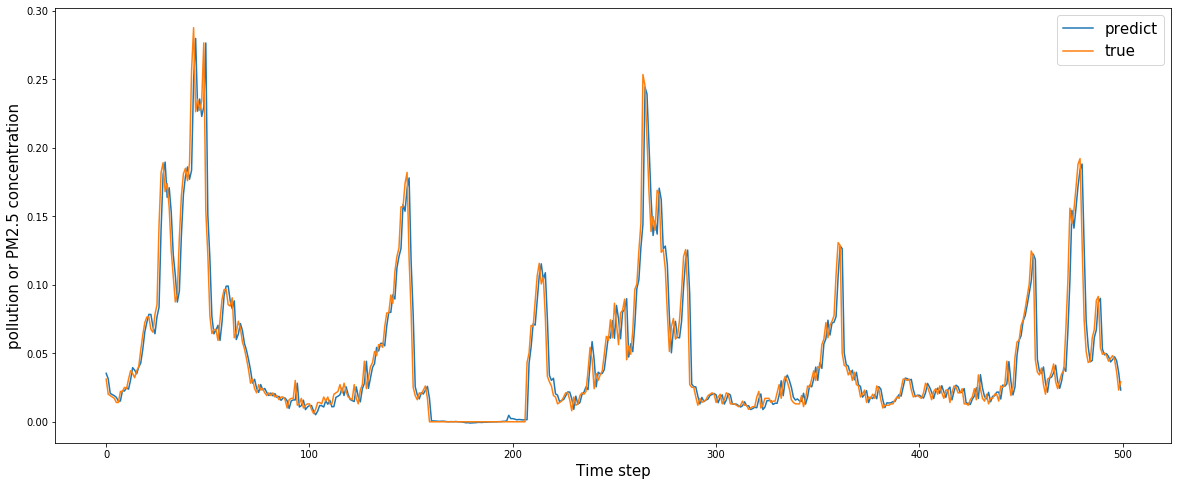

In [41]:
''' Plotting the first 500 entries to see prediction '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(test_y[:500], label='true')
pyplot.legend()

pyplot.ylabel('pollution or PM2.5 concentration', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

pyplot.show()

In [42]:

model_gru = Sequential()
model_gru.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(Dense(1))
model_gru.compile(loss='mae', optimizer='adam')

history_gru=model_gru.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# To save model
model_gru.save('GRU_model.hdf5')
# Training Phase
model.summary()

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0624 - val_loss: 0.0531
Epoch 2/50
 - 1s - loss: 0.0342 - val_loss: 0.0500
Epoch 3/50
 - 1s - loss: 0.0189 - val_loss: 0.0306
Epoch 4/50
 - 1s - loss: 0.0155 - val_loss: 0.0198
Epoch 5/50
 - 1s - loss: 0.0149 - val_loss: 0.0162
Epoch 6/50
 - 1s - loss: 0.0148 - val_loss: 0.0147
Epoch 7/50
 - 1s - loss: 0.0146 - val_loss: 0.0136
Epoch 8/50
 - 1s - loss: 0.0147 - val_loss: 0.0134
Epoch 9/50
 - 1s - loss: 0.0150 - val_loss: 0.0135
Epoch 10/50
 - 1s - loss: 0.0150 - val_loss: 0.0136
Epoch 11/50
 - 1s - loss: 0.0150 - val_loss: 0.0137
Epoch 12/50
 - 1s - loss: 0.0149 - val_loss: 0.0138
Epoch 13/50
 - 1s - loss: 0.0150 - val_loss: 0.0137
Epoch 14/50
 - 1s - loss: 0.0150 - val_loss: 0.0136
Epoch 15/50
 - 1s - loss: 0.0149 - val_loss: 0.0135
Epoch 16/50
 - 1s - loss: 0.0149 - val_loss: 0.0135
Epoch 17/50
 - 1s - loss: 0.0149 - val_loss: 0.0137
Epoch 18/50
 - 1s - loss: 0.0150 - val_loss: 0.0136
Epoch 19/50
 - 1s - loss

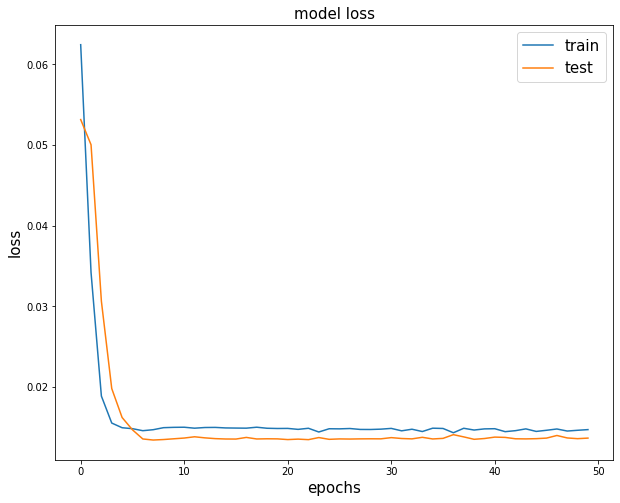

In [43]:
# plot history
pyplot.plot(history_gru.history['loss'], label='train')
pyplot.plot(history_gru.history['val_loss'], label='test')

pyplot.title('model loss',size=15)
pyplot.ylabel('loss',size=15)
pyplot.xlabel('epochs',size=15)
pyplot.legend(loc='upper right',fontsize=15)

pyplot.show()

In [44]:
''' Predicting 1 years data based on 5 years of previous data '''
yhat_gru = model_gru.predict(test_X)



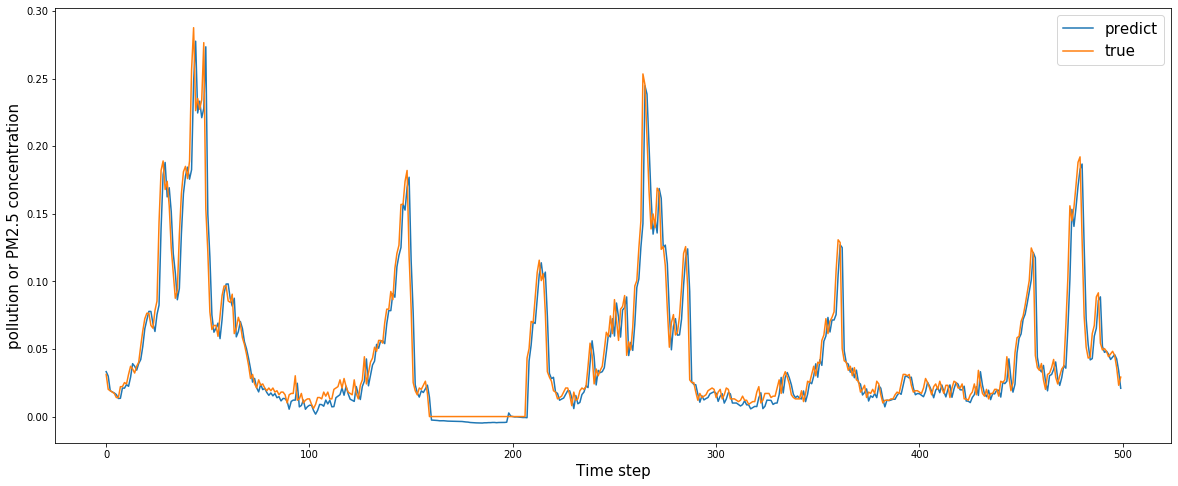

In [45]:
''' Plotting the first 500 entries to see prediction '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat_gru[:500], label='predict')
pyplot.plot(test_y[:500], label='true')
pyplot.legend()

pyplot.ylabel('pollution or PM2.5 concentration', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

pyplot.show()

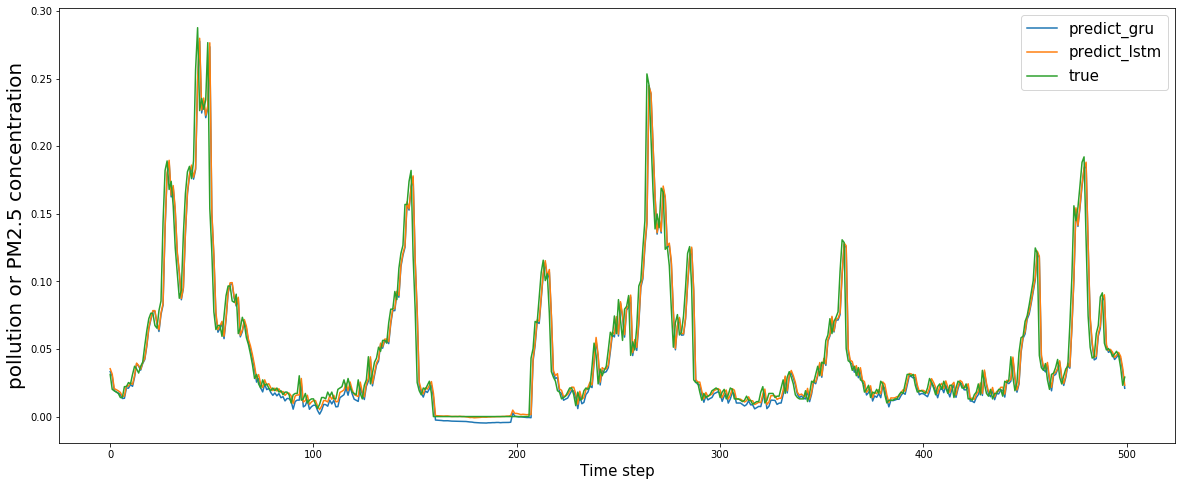

In [46]:
''' Plotting the first 500 entries to see prediction '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat_gru[:500], label='predict_gru')
pyplot.plot(yhat[:500], label='predict_lstm')
pyplot.plot(test_y[:500], label='true')
pyplot.legend()

pyplot.ylabel('pollution or PM2.5 concentration', size=20)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

pyplot.show()

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [47]:
# make a prediction
yhat = model.predict(test_X)

# make a prediction
yhat_gru = model_gru.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for forecast
inv_yhat_gru = concatenate((yhat_gru, test_X[:, 1:]), axis=1)
inv_yhat_gru = scaler.inverse_transform(inv_yhat_gru)
inv_yhat_gru = inv_yhat_gru[:,0]


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse1 = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE FOR LSTM: %.3f' % rmse1)

# calculate RMSE
rmse2 = sqrt(mean_squared_error(inv_y, inv_yhat_gru))
print('Test RMSE for GRU: %.3f' % rmse2)

Test RMSE FOR LSTM: 26.367
Test RMSE for GRU: 26.436
